In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats

In [3]:
CLINGEN_GENES = (
        '/Users/markus/in-silico-vg-analysis/experiments_data/'
        'dataset3_ClinGen/dataset3_clingen_gene_level_summary_2812.csv')

In [4]:
def load_analysis_data(path: Path) -> pd.DataFrame:
    # load with polars for speed then convert to pandas for plotting
    if not path.exists():
        raise FileNotFoundError(f'summary file not found at: {path}')

    return pl.read_csv(path).to_pandas()


def plot_validation_vg(df: pd.DataFrame) -> None:
    # observed (gtex/aneva) vs predicted variance
    # remove zeros for log-log plot
    mask = (df['vg_eqtl'] > 0) & (df['vg_predicted_sum'] > 0)
    data = df[mask]

    r_spearman, p_val = stats.spearmanr(data['vg_eqtl'], data['vg_predicted_sum'])

    plt.figure(figsize=(8, 6))
    sns.regplot(
        data=data, x='vg_eqtl', y='vg_predicted_sum',
        scatter_kws={'alpha': 0.3, 's': 10}, line_kws={'color': 'red'}
    )
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'variance validation: observed vs predicted\nspearman r: {r_spearman:.3f} (p={p_val:.2e})')
    plt.xlabel('observed vg (eqtl/aneva)')
    plt.ylabel('predicted vg (alphagenome)')
    plt.grid(True, which='both', ls='-', alpha=0.2)


def plot_constraint_impact(df: pd.DataFrame) -> None:
    # impact of selection (loeuf) on predicted variance
    data = df.dropna(subset=['loeuf_score', 'vg_predicted_sum']).copy()
    data = data[data['vg_predicted_sum'] > 0]

    # bin loeuf into deciles
    data['loeuf_decile'] = pd.qcut(data['loeuf_score'], 10, labels=range(1, 11))

    # t-test between most constrained (d1) and least constrained (d10)
    d1 = data[data['loeuf_decile'] == 1]['vg_predicted_sum']
    d10 = data[data['loeuf_decile'] == 10]['vg_predicted_sum']
    t_stat, p_val = stats.ttest_ind(np.log1p(d1), np.log1p(d10))

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data, x='loeuf_decile', y='vg_predicted_sum', palette='viridis')
    plt.yscale('log')
    plt.title(f'predicted variance vs gene constraint (loeuf)\nt-test d1 vs d10 p-val: {p_val:.2e}')
    plt.xlabel('loeuf decile (1=most constrained)')
    plt.ylabel('vg predicted sum')


def plot_spatial_architecture(df: pd.DataFrame) -> None:
    # compare impact in promoter vs exon body
    cols = ['mean_abs_effect_promo', 'mean_abs_effect_exon']
    data = df.dropna(subset=cols)

    # related samples t-test (same genes)
    t_stat, p_val = stats.ttest_rel(data[cols[0]], data[cols[1]])

    plot_data = data[cols].melt(var_name='region', value_name='lfc')

    plt.figure(figsize=(8, 6))
    sns.violinplot(data=plot_data, x='region', y='lfc', inner='quart')
    plt.title(f'spatial impact: promoter vs body\npaired t-test p-val: {p_val:.2e}')
    plt.ylabel('mean absolute lfc')


def plot_size_bias(df: pd.DataFrame) -> None:
    # check if variance is just a proxy for gene length
    data = df[df['vg_predicted_sum'] > 0]
    r_pearson, _ = stats.pearsonr(np.log1p(data['genomic_length']), np.log1p(data['vg_predicted_sum']))

    plt.figure(figsize=(8, 6))
    plt.hexbin(
        data['genomic_length'], data['vg_predicted_sum'],
        gridsize=30, cmap='Blues', bins='log', xscale='log', yscale='log'
    )
    plt.colorbar(label='log10(count)')
    plt.title(f'length scalability: genomic length vs predicted vg\npearson r: {r_pearson:.3f}')
    plt.xlabel('genomic length (bp)')
    plt.ylabel('vg predicted sum')


def plot_parameter_heatmap(df: pd.DataFrame) -> None:
    # correlation between top biological and model parameters
    key_cols = [
        'vg_predicted_sum', 'mean_abs_effect_exon', 'tpm',
        'loeuf_score', 'ncRVIS', 'genomic_length', 'n_variants_exon'
    ]
    corr = df[key_cols].corr(method='spearman')

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
    plt.title('parameter interaction matrix (spearman correlation)')


def run_comprehensive_analysis(file_path: str) -> None:
    path = Path(file_path)
    df = load_analysis_data(path)

    # set visual style
    sns.set_theme(style='whitegrid')

    plot_validation_vg(df)
    plot_constraint_impact(df)
    plot_spatial_architecture(df)
    plot_size_bias(df)
    plot_parameter_heatmap(df)

    plt.show()

/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_66489/1597774164.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='loeuf_decile', y='vg_predicted_sum', palette='viridis')


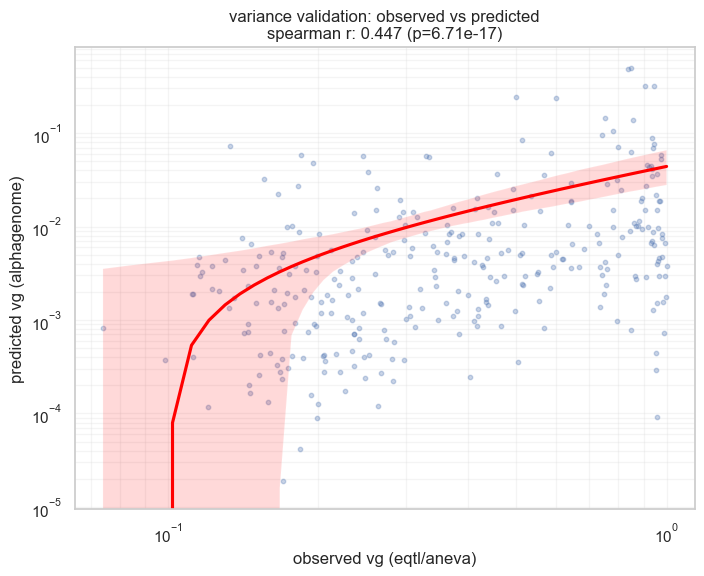

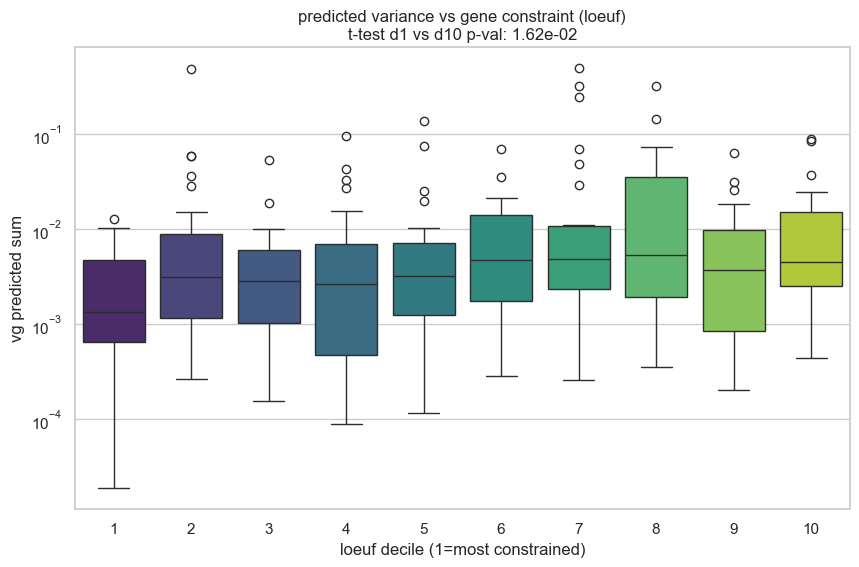

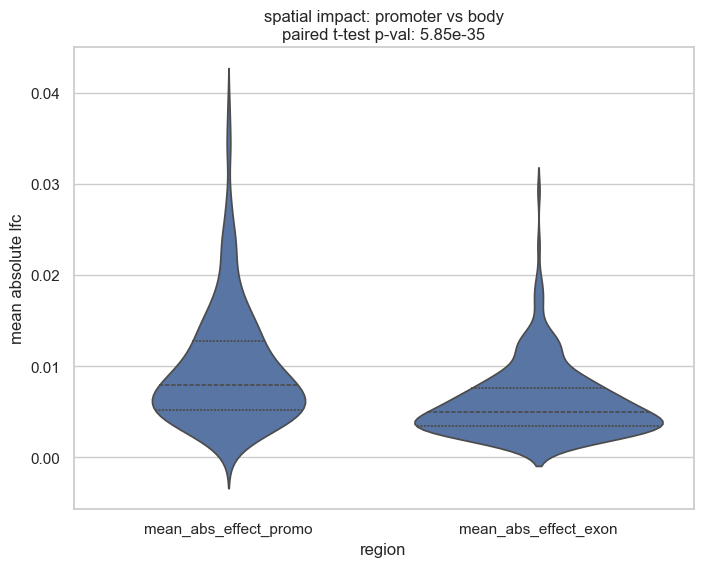

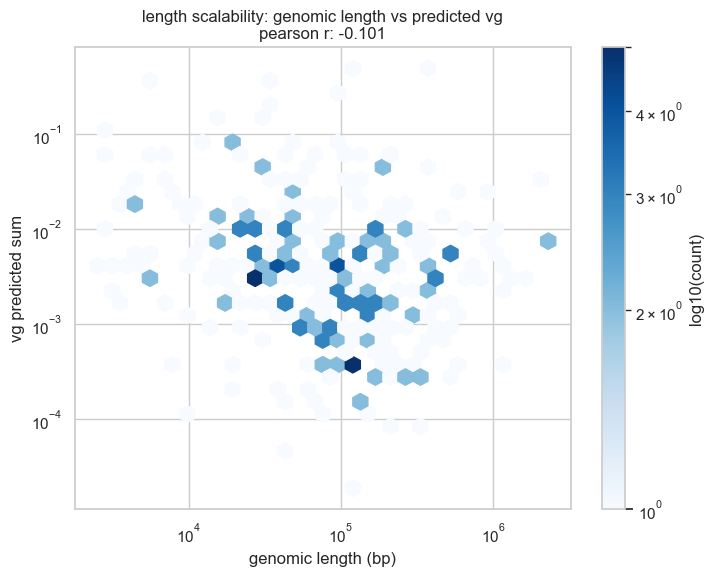

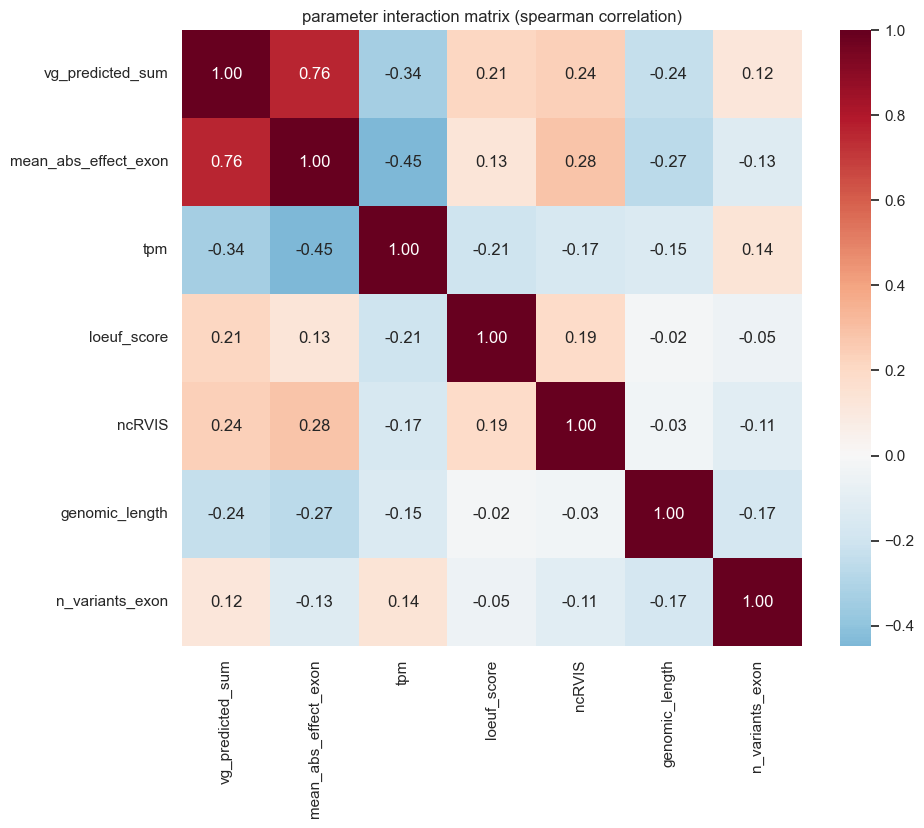

In [5]:
run_comprehensive_analysis(CLINGEN_GENES)